### Imports

In [27]:
%matplotlib inline

In [19]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
# import tkinter


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data formatting en reading

In [3]:
SOS_token = 0 # Start of sentence
EOS_token = 1 # End of sentence

In [4]:
class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def readLang(self, s):
        for index, value in s.items():
            value = normalizeString(value)
            self.addSentence(value)

    def showLang(self):
        print("-- NL Language")
        print("Word count: ", sum(self.word2count.values()))
        print("Vocabe size: ", self.n_words)

In [5]:
class MRLanguage:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(', '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def readLang(self, s):
        for index, value in s.items():
            value = normalizeMRString(value)
            self.addSentence(value)

    def showLang(self):
        print("-- MR Language")
        print("Word count: ", sum(self.word2count.values()))
        print("Vocabe size: ", self.n_words)

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?_]+", r" ", s)
    return s

def normalizeMRString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r'\[[^]]*\]', r"", s) # TODO: Data in de square brackets is lost!!
    # s = re.sub(r"[\[*\]]+", r" ", s)
    return s

In [7]:
def indexesFromSentence(lang, sentence, delimeter=' '):
    indices = [lang.word2index[word] for word in sentence.split(delimeter)]
    return torch.tensor(indices)

def sentenceFromIndexes(lang, indexes, delimeter=' '):
    sentence = ''
    for i in indexes:
        sentence += str(lang.index2word[i.item()]) + delimeter
    
    return sentence


def get_output_data(file):
    corpus_df = pd.read_csv(file)
    lang_df = corpus_df['ref']

    natural_lang = Language()
    natural_lang.readLang(lang_df)
    # corpus_df['ref'] = corpus_df['ref'].astype(str) + ' eos'
    corpus_df['ref'] = corpus_df['ref'].apply(lambda x: normalizeString(x))
    corpus_df['ref'] = corpus_df['ref'].apply(lambda x: indexesFromSentence(natural_lang, x))

    return corpus_df['ref'], natural_lang

def get_input_data(file):
    corpus_df = pd.read_csv(file)
    lang_df = corpus_df['mr']

    mr_lang = MRLanguage()
    mr_lang.readLang(corpus_df['mr'])
    # corpus_df['mr'] = corpus_df['mr'].astype(str) + ', eos'
    corpus_df['mr'] = corpus_df['mr'].apply(lambda x: normalizeMRString(x))
    corpus_df['mr'] = corpus_df['mr'].apply(lambda x: indexesFromSentence(mr_lang, x, delimeter=", "))

    return corpus_df['mr'], mr_lang

Actually reading the data

In [8]:
# GET DATA
print("Reading...")
path = "delexicalized/delex_only.csv"
input_data, mr_lang = get_input_data(path) #TODO: Correctly read all info of labels
target_data, nl_lang = get_output_data(path)

print(mr_lang.showLang())
print(nl_lang.showLang())

Reading...
-- MR Language
Word count:  10632
Vocabe size:  10
None
-- NL Language
Word count:  32610
Vocabe size:  671
None


### Models

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=75):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training

In [11]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=75):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):   
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input
        
        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def trainIters(encoder, decoder, n_epoch, learning_rate=0.01):
    print("Started training!")
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    for epoch in range(1, n_epoch + 1):
        print(epoch)
        for i in range(10): #range(len(input_data)):
            input_tensor = input_data[i].view(-1, 1)
            target_tensor = target_data[i].view(-1, 1)
    #         print("Input: ", input_tensor)
    #         print("Target: ", target_tensor)


            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            
        print_loss_avg = print_loss_total / len(input_data)
        print_loss_total = 0
        print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epoch),
                                     epoch, epoch / n_epoch * 100, print_loss_avg))

        plot_loss_avg = plot_loss_total / len(input_data)
        plot_losses.append(plot_loss_avg)
        print(plot_loss_avg)
        print(plot_losses)
        plot_loss_total = 0

    print(plot_losses)
    showPlot(plot_losses)
    print("Done!")
    return plot_losses

### Plotting results

In [14]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### Evaluation

In [15]:
def evaluate(encoder, decoder, input_tensor, max_length=75):
    with torch.no_grad():
#         sentence = sentenceFromIndexes(mr_lang, input_tensor, delimeter=", ")
#         input_tensor = indexesFromSentence(mr_lang, sentence, delimeter=", ")
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(nl_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        index = random.randint(0, len(input_data) - 1)
        input_sentence = sentenceFromIndexes(mr_lang, input_data[index], delimeter=", ")
        target_sentence = sentenceFromIndexes(nl_lang, target_data[index], delimeter=" ")
        
        print('>', input_sentence)
        print('=', target_sentence)
        output_words, attentions = evaluate(encoder, decoder, input_data[i])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Running

In [17]:
n_epoch = 20

hidden_size = 256

encoder1 = EncoderRNN(mr_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, nl_lang.n_words, dropout_p=0.1).to(device)

plot_losses = trainIters(encoder1, attn_decoder1, n_epoch)

Started training!
1
0m 0s (- 0m 18s) (1 5%) 0.0300
0.029985359039007776
[0.029985359039007776]
2
0m 1s (- 0m 17s) (2 10%) 0.0235
0.023547588829632496
[0.029985359039007776, 0.023547588829632496]
3
0m 2s (- 0m 16s) (3 15%) 0.0212
0.021213746598317533
[0.029985359039007776, 0.023547588829632496, 0.021213746598317533]
4
0m 3s (- 0m 15s) (4 20%) 0.0201
0.020114433493330995
[0.029985359039007776, 0.023547588829632496, 0.021213746598317533, 0.020114433493330995]
5
0m 4s (- 0m 14s) (5 25%) 0.0194
0.01944616015048159
[0.029985359039007776, 0.023547588829632496, 0.021213746598317533, 0.020114433493330995, 0.01944616015048159]
6
0m 5s (- 0m 13s) (6 30%) 0.0192
0.019232524787807757
[0.029985359039007776, 0.023547588829632496, 0.021213746598317533, 0.020114433493330995, 0.01944616015048159, 0.019232524787807757]
7
0m 6s (- 0m 11s) (7 35%) 0.0187
0.018698963829737427
[0.029985359039007776, 0.023547588829632496, 0.021213746598317533, 0.020114433493330995, 0.01944616015048159, 0.019232524787807757, 0

> name, food, pricerange, customer rating, area, familyfriendly, near, 
= name_x located area_x near_x is not familyfriendly_x the prices are pricerange_x and the customer rating is customer rating_x . 
< name_x eattype_x near_x eattype_x near_x near near_x eattype_x near_x near the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

> name, food, pricerange, area, 
= pricerange_x expensive food_x restaurant in the area_x called name_x . 
< name_x eattype_x near_x near near_x eattype_x near_x near near_x the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

> name, food, customer rating, familyfriendly, near, 
= name_x familyfriendly_x near near_x offering food_x food with a customer rating_x customer rating . 
< name_x is a food_x eattype_x near_x eattype_x near . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

<Figure size 432x288 with 0 Axes>

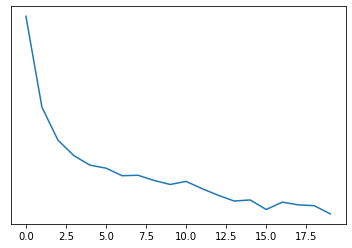

In [29]:
evaluateRandomly(encoder1, attn_decoder1)